## AMATH 582 Final Project
### Rachel Carroll and Shannon Dow
### March 19, 2020

Import Packages

In [355]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import interpolate
import fair
from matplotlib import pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)

Define functions

In [356]:
def SSP_to_emissions_matrix(df):
    pollutant_list=df.VARIABLE.unique()
    region_list=df.REGION.unique()
    ssp_list=df.SCENARIO.unique()
    years = np.array(df.YEAR.unique())
    emission_data = pd.DataFrame() 
    emission_data['YEAR']=years
    for pollutant in pollutant_list:
        for region in region_list:
            for ssp in ssp_list:
                emission_vec = df.EMISSIONS[(df.VARIABLE==pollutant)&(df.REGION==region)&(df.SCENARIO==ssp)]
                emission_data[pollutant+'-'+region+'-'+ssp]= np.array(emission_vec)
    return emission_data

def fair_format_emissions(df):
    fair_emissions_data = {'YEAR': df.YEAR,
                      'FossilCO2': df['CO2'],
                      'OtherCO2': 0,
                      'CH4': df['CH4'],
                      'N2O': df['N2O'],
                      'SOx': df['Sulfur'], #?
                      'CO': df['CO'],
                      'NMVOC': df['VOC'], #?
                      'NOx': df['NOx'] ,
                      'BC': df['BC'],
                      'OC': df['OC'],
                      'NH3':df['NH3'],
                      'CF4':  df['CF4'],
                      'C2F6':df['C2F6'],
                      'C6F14': 0,'HFC23': 0, 'HFC32': 0,'HFC43_10': 0,
                      'HFC125': 0,'HFC134a': 0,'HFC143a': 0,'HFC227ea': 0,'HFC245fa': 0,
                      'SF6': df['SF6'],
                      'CFC_11': 0,'CFC_12': 0,'CFC_113': 0,
                      'CFC_114': 0,'CFC_115': 0,'CARB_TET': 0,'MCF': 0,'HCFC_22': 0,
                      'HCFC_141B': 0,'HCFC_142B': 0,'HALON1211': 0,'HALON1202': 0,
                      'HALON1301': 0,'HALON2402': 0,'CH3BR': 0,'CH3CL': 0}
    fair_emissions_data = pd.DataFrame(fair_emissions_data)
    return(fair_emissions_data)

def fair_scm_by_pollutant(emissions_df,pollutant_list):
 #   fair_concentration = pd.DataFrame() 
 #   fair_forcing = pd.DataFrame() 
    fair_temp = pd.DataFrame() 
    for pollutant in pollutant_list:
        pollutant_emissions = emissions_df.copy()
        for column in pollutant_emissions.columns:
            if column != 'YEAR' and column != pollutant:
                pollutant_emissions[column]=0
        pollutant_emissions = pd.DataFrame(pollutant_emissions)
        C, F, T = fair.forward.fair_scm(emissions=pollutant_emissions.values)
    #    fair_concentration[pollutant]=np.array(C)
   #     fair_forcing[pollutant]=np.array(F)
        fair_temp[pollutant]=np.array(T)
        T=None 
        F=None 
        C=None        
    return fair_temp

### Section 1: Prepare Data
Read in all data from the SSP csv file and interpolate to turn decadal data to annual.

In [357]:
#Pull in SSP csv file (Chose Rach or Snoonz path)
#SSP_all_orig = pd.read_csv('/Users/shannondow/Desktop/ClimateModeling/SSP_CMIP6_201811.csv')
SSP_all_orig = pd.read_csv('/Users/rachelcarroll/Documents/ClimateModeling/SSP_CMIP6_201811.csv/SSP_CMIP6_201811.csv')

#add blank columns for missing years
SSP_all = SSP_all_orig.copy()
for i in range(2016,2100):
        if i % 10 != 0: 
            SSP_all[i]=np.nan
SSP_all[1765]=0                  #these loops are not needed for emissions but are for the fair model
for i in range(1766,2015):
            SSP_all[i]=np.nan
for i in range(2101,2501):
            SSP_all[i]=np.nan
            
#melt to unpivot the data so there is a column for year and emissions
SSP_all = SSP_all.melt(id_vars=['MODEL','SCENARIO','REGION','UNIT','VARIABLE'], var_name='YEAR', value_name='EMISSIONS')
#set all year values as integers
SSP_all.YEAR = [int(x) for x in SSP_all.YEAR]

#interpolate 
SSP_all=SSP_all.sort_values(by=['REGION', 'UNIT','VARIABLE','SCENARIO','YEAR'])
SSP_all.EMISSIONS=SSP_all.EMISSIONS.interpolate()

Select World data split into three SSP scenarios of interest and interpolate to fill in NaN rows. 

In [379]:
SSP_world = SSP_all[(SSP_all.REGION == 'World')]
SSP_world=SSP_world.sort_values(by=['REGION', 'UNIT','VARIABLE','SCENARIO','YEAR'])
SSP_world['VARIABLE']=SSP_world['VARIABLE'].str.replace('CMIP6 Emissions', '')
SSP_world['VARIABLE']=SSP_world['VARIABLE'].str.replace('|', '')
SSP_world.loc[SSP_world['VARIABLE'].str.len()<7, 'TOTAL'] = 'True'
SSP_world = SSP_world[SSP_world.TOTAL == 'True']

# #Divide by SSP Scenarios of interest
SSP1_world_total_industry = SSP_world[(SSP_world.SCENARIO=='SSP1-19')]
SSP3_world_total_industry = SSP_world[(SSP_world.SCENARIO=='SSP3-70 (Baseline)')]
SSP5_world_total_industry = SSP_world[(SSP_world.SCENARIO=='SSP5-85 (Baseline)')]


Select regional data split into three SSP scenarios of interest and interpolate to fill in NaN rows. 

In [375]:
SSP_regions = SSP_all[(SSP_all.REGION != 'World')&(SSP_all.YEAR >2014)&(SSP_all.YEAR <2101)]
SSP_regions=SSP_regions.sort_values(by=['REGION', 'VARIABLE','SCENARIO','YEAR'])
SSP_regions['VARIABLE']=SSP_regions['VARIABLE'].str.replace('CMIP6 Emissions', '')
SSP_regions['VARIABLE']=SSP_regions['VARIABLE'].str.replace('|', '')
SSP_regions.loc[SSP_regions['VARIABLE'].str.len()<7, 'TOTAL'] = 'True'
SSP_regions = SSP_regions[SSP_regions.TOTAL == 'True']
SSP_regions=SSP_regions.sort_values(by=['REGION', 'VARIABLE','SCENARIO','YEAR'])

SSP1_region_total_industry = SSP_regions[(SSP_regions.SCENARIO=='SSP1-19')]
SSP3_region_total_industry = SSP_regions[(SSP_regions.SCENARIO=='SSP3-70 (Baseline)')]
SSP5_region_total_industry = SSP_regions[(SSP_regions.SCENARIO=='SSP5-85 (Baseline)')]

#### Format emissions data into vectorized matrices
This function reformats the SSP data so there is a column for every pollutant/scenario/region combination in the dataframe that is fed into the funtion. The output file is in the format that can be SVD'd directly for the emissions analysis

In [506]:
SSP1_emission_data=SSP_to_emissions_matrix(SSP1_world_total_industry)
SSP3_emission_data=SSP_to_emissions_matrix(SSP3_world_total_industry)
SSP5_emission_data=SSP_to_emissions_matrix(SSP5_world_total_industry)

SSP1_regions_emission=SSP_to_emissions_matrix(SSP1_region_total_industry)
SSP3_regions_emission=SSP_to_emissions_matrix(SSP3_region_total_industry)
SSP5_regions_emission=SSP_to_emissions_matrix(SSP5_region_total_industry)

#### Format emissions data for the FaIR model 
(to match exact format of RCP data files)

In [ ]:
ssp1_emissions_fair_data=fair_format_emissions(SSP1_emission_data)
ssp3_emissions_fair_data=fair_format_emissions(SSP3_emission_data)
ssp5_emissions_fair_data=fair_format_emissions(SSP5_emission_data)

#### Format emissions data for the FaIR model 

In [ ]:
# Run the FaIR model on the entire datasets
C_SSP1, F_SSP1, T_SSP1 = fair.forward.fair_scm(emissions=ssp1_emissions_fair_data.values)
C_SSP3, F_SSP3, T_SSP3 = fair.forward.fair_scm(emissions=ssp3_emissions_fair_data.values)
C_SSP5, F_SSP5, T_SSP5 = fair.forward.fair_scm(emissions=ssp5_emissions_fair_data.values)
# Run the FaIR model one pollutant at a time
SSP1_Temp=fair_scm_by_pollutant(ssp1_emissions_fair_data,col_list)
SSP3_Temp=fair_scm_by_pollutant(ssp3_emissions_fair_data,col_list)
SSP5_Temp=fair_scm_by_pollutant(ssp5_emissions_fair_data,col_list)

### Section 2: Emissions - Singular Value Decmposition by Pollutant

In [507]:
SSP1=SSP1_emission_data=SSP1_emission_data.iloc[:,1:15] #remove year
SSP3=SSP3_emission_data=SSP3_emission_data.iloc[:,1:15]
SSP5=SSP5_emission_data=SSP5_emission_data.iloc[:,1:15]

#subtract the mean
for i in range(0,14):
    #print(i)
    SSP1.iloc[:,i] =  SSP1.iloc[:,i] -  SSP1.iloc[:,i].mean()
    SSP3.iloc[:,i] =  SSP3.iloc[:,i] -  SSP3.iloc[:,i].mean()
    SSP5.iloc[:,i] =  SSP5.iloc[:,i] -  SSP5.iloc[:,i].mean()
    
u1, s1, v1 = np.linalg.svd(SSP1, full_matrices=False)
u3, s3, v3 = np.linalg.svd(SSP3, full_matrices=False)
u5, s5, v5 = np.linalg.svd(SSP5, full_matrices=False)

Text(0.5, 0.98, 'Singular Vectors of Emissions by Pollutant')

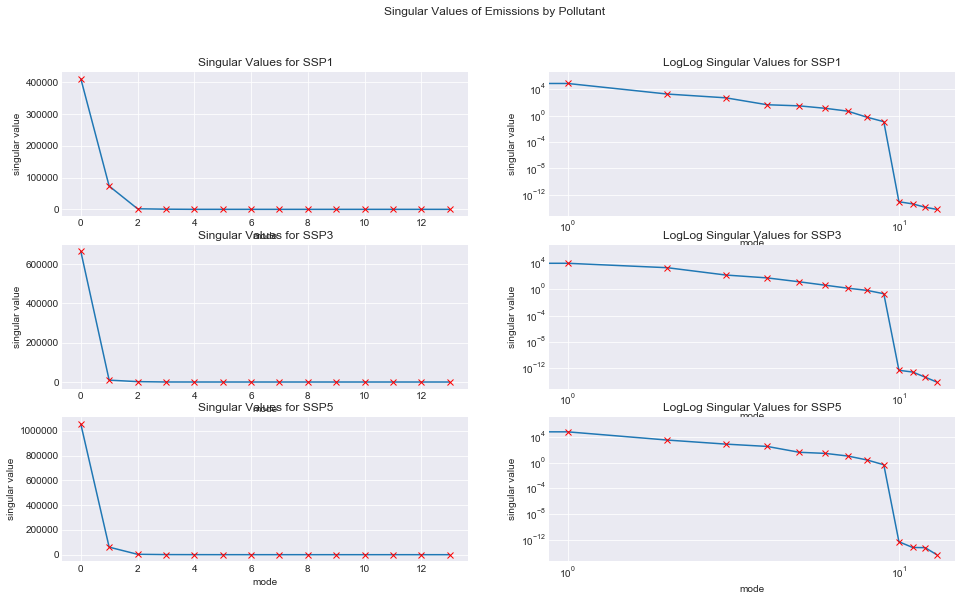

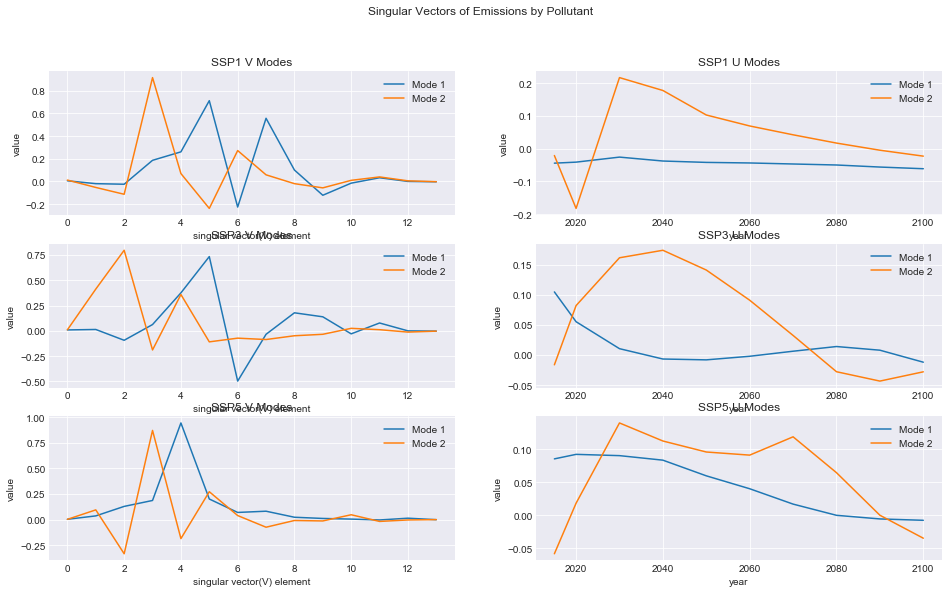

In [508]:
plt.figure(1)
plt.subplot(321)
plt.plot(s1)
plt.plot(s1,'rx')
plt.title('Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(322)
plt.loglog(s1)
plt.loglog(s1,'rx')
plt.title('LogLog Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(323)
plt.plot(s3)
plt.plot(s3,'rx')
plt.title('Singular Values for SSP3')
plt.xlabel('mode');plt.ylabel('singular value')
plt.subplot(324)
plt.loglog(s3)
plt.loglog(s3,'rx')
plt.title('LogLog Singular Values for SSP3')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(325)
plt.plot(s5)
plt.plot(s5,'rx')
plt.title('Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(326)
plt.loglog(s5)
plt.loglog(s5,'rx')
plt.title('LogLog Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.suptitle('Singular Values of Emissions by Pollutant')

plt.figure(2)
plt.subplot(321)
plt.plot(v1[:,1],label='Mode 1')
plt.plot(v1[:,2],label='Mode 2')
plt.title('SSP1 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(322)
plt.plot(years[start_indx:end_indx],u1[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],u1[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP1 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(323)
plt.plot(v3[:,1],label='Mode 1')
plt.plot(v3[:,2],label='Mode 2')
plt.title('SSP3 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(324)
plt.plot(years[start_indx:end_indx],u3[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],u3[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP3 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(325)
plt.plot(v5[:,1],label='Mode 1')
plt.plot(v5[:,2],label='Mode 2')
plt.title('SSP5 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(326)
plt.plot(years[start_indx:end_indx],u5[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],u5[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP5 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()
plt.suptitle('Singular Vectors of Emissions by Pollutant')



Text(0.5, 0.98, 'Dominant Emissions over Time Behavior')

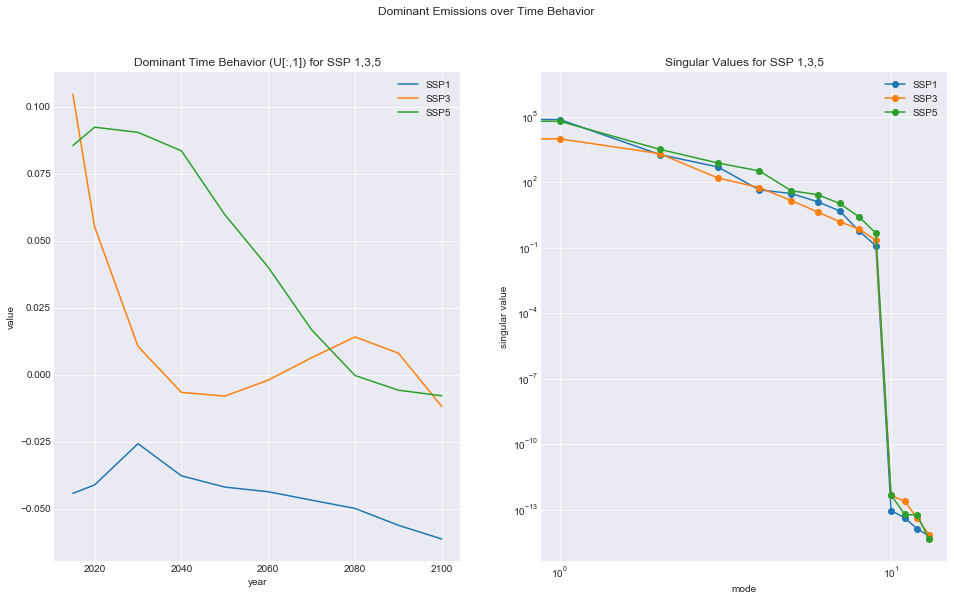

In [509]:
plt.figure(3)
plt.subplot(121)
plt.plot(years[start_indx:end_indx], u1[start_indx:end_indx,1],label = 'SSP1')
plt.plot(years[start_indx:end_indx], u3[start_indx:end_indx,1],label = 'SSP3')
plt.plot(years[start_indx:end_indx], u5[start_indx:end_indx,1],label = 'SSP5')
plt.title('Dominant Time Behavior (U[:,1]) for SSP 1,3,5')
plt.xlabel('year')
plt.ylabel('value')
plt.legend()
plt.subplot(122)
plt.loglog(s1,'o-',label = 'SSP1')
plt.loglog(s3,'o-',label = 'SSP3')
plt.loglog(s5,'o-',label = 'SSP5')
plt.title('Singular Values for SSP 1,3,5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.legend()
plt.suptitle("Dominant Emissions over Time Behavior")

### Section 3: Emissions - Singular Value Decmposition by Pollutant and Region

In [514]:
rSSP1=SSP1_emission_data=SSP1_regions_emission.iloc[:,1:85] #remove year
rSSP3=SSP3_emission_data=SSP3_regions_emission.iloc[:,1:85]
rSSP5=SSP5_emission_data=SSP5_regions_emission.iloc[:,1:85]

#subtract the mean
for i in range(0,84):
    #print(i)
    rSSP1.iloc[:,i] =  rSSP1.iloc[:,i] -  rSSP1.iloc[:,i].mean()
    rSSP3.iloc[:,i] =  rSSP3.iloc[:,i] -  rSSP3.iloc[:,i].mean()
    rSSP5.iloc[:,i] =  rSSP5.iloc[:,i] -  rSSP5.iloc[:,i].mean()

ur1, sr1, vr1 = np.linalg.svd(rSSP1, full_matrices=False)
ur3, sr3, vr3 = np.linalg.svd(rSSP3, full_matrices=False)
ur5, sr5, vr5 = np.linalg.svd(rSSP5, full_matrices=False)

Text(0.5, 0.98, 'Singular Vectors of Emissions by Pollutant')

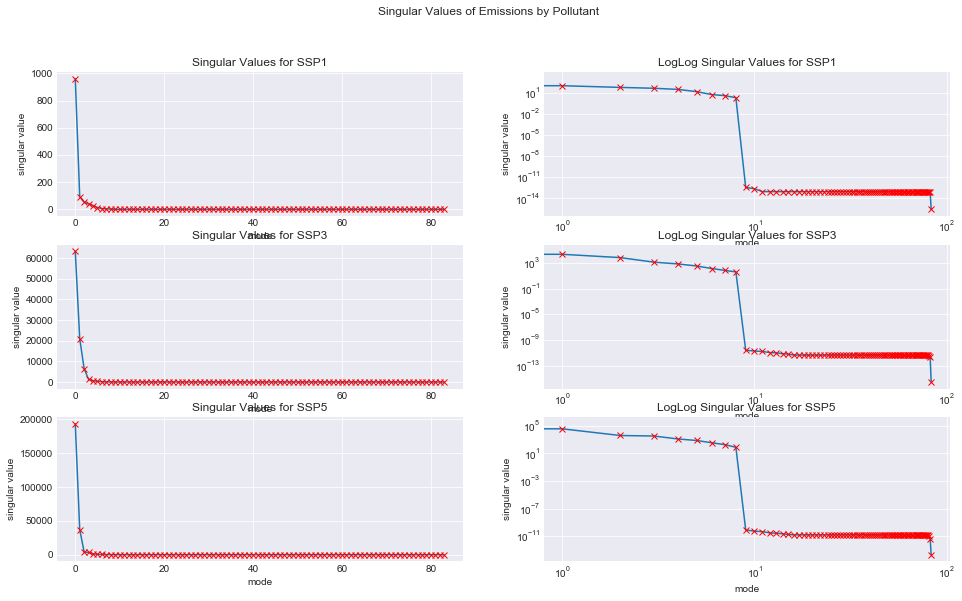

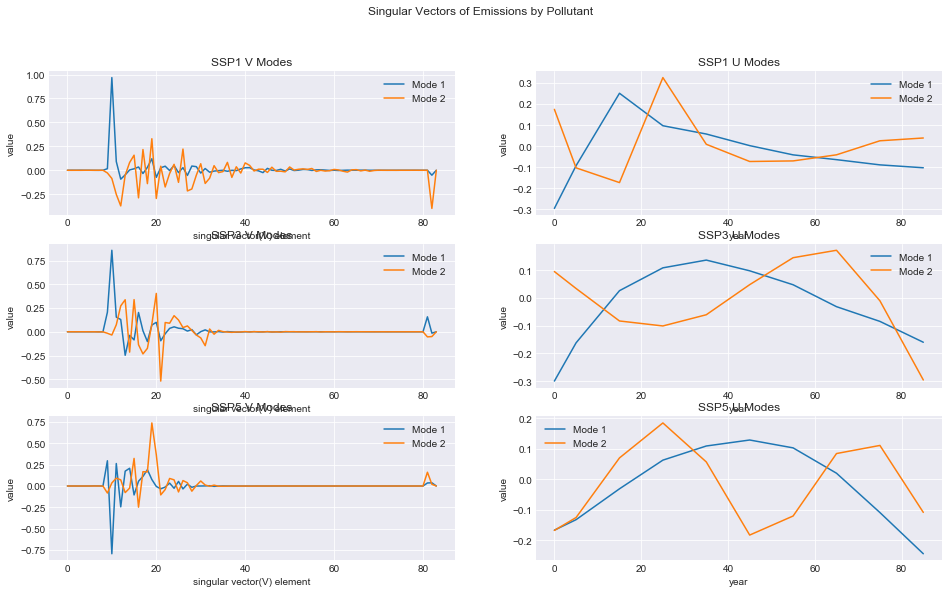

In [515]:
plt.figure(1)
plt.subplot(321)
plt.plot(sr1)
plt.plot(sr1,'rx')
plt.title('Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(322)
plt.loglog(sr1)
plt.loglog(sr1,'rx')
plt.title('LogLog Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(323)
plt.plot(sr3)
plt.plot(sr3,'rx')
plt.title('Singular Values for SSP3')
plt.xlabel('mode');plt.ylabel('singular value')
plt.subplot(324)
plt.loglog(sr3)
plt.loglog(sr3,'rx')
plt.title('LogLog Singular Values for SSP3')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(325)
plt.plot(sr5)
plt.plot(sr5,'rx')
plt.title('Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(326)
plt.loglog(sr5)
plt.loglog(sr5,'rx')
plt.title('LogLog Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.suptitle('Singular Values of Emissions by Pollutant')

plt.figure(2)
plt.subplot(321)
plt.plot(vr1[:,1],label='Mode 1')
plt.plot(vr1[:,2],label='Mode 2')
plt.title('SSP1 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(322)
plt.plot(ur1[:,1],label='Mode 1')
plt.plot(ur1[:,2],label='Mode 2')
plt.title('SSP1 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(323)
plt.plot(vr3[:,1],label='Mode 1')
plt.plot(vr3[:,2],label='Mode 2')
plt.title('SSP3 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(324)
plt.plot(ur3[:,1],label='Mode 1')
plt.plot(ur3[:,2],label='Mode 2')
plt.title('SSP3 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(325)
plt.plot(vr5[:,1],label='Mode 1')
plt.plot(vr5[:,2],label='Mode 2')
plt.title('SSP5 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(326)
plt.plot(ur5[:,1],label='Mode 1')
plt.plot(ur5[:,2],label='Mode 2')
plt.title('SSP5 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()
plt.suptitle('Singular Vectors of Emissions by Pollutant')


### Section 4: Temperature - Singular Value Decomposition by Pollutant 

In [521]:
tSSP1=SSP1_Temp.copy()
tSSP3=SSP3_Temp.copy()
tSSP5=SSP5_Temp.copy()

#subtract the mean
for i in range(0,13):
    #print(i)
    tSSP1.iloc[:,i] =  tSSP1.iloc[:,i] -  tSSP1.iloc[:,i].mean()
    tSSP3.iloc[:,i] =  tSSP3.iloc[:,i] -  tSSP3.iloc[:,i].mean()
    tSSP5.iloc[:,i] =  tSSP5.iloc[:,i] -  tSSP5.iloc[:,i].mean()
    
ut1, st1, vt1 = np.linalg.svd(SSP1_Temp, full_matrices=False)
ut3, st3, vt3 = np.linalg.svd(SSP3_Temp, full_matrices=False)
ut5, st5, vt5 = np.linalg.svd(SSP5_Temp, full_matrices=False)

Text(0.5, 0.98, 'Singular Vectors of Temperature by Pollutant')

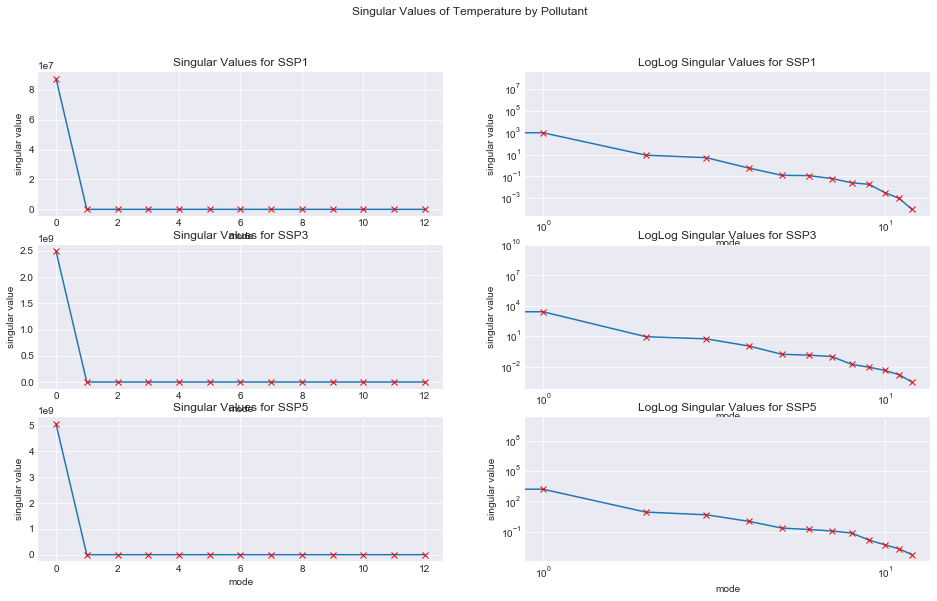

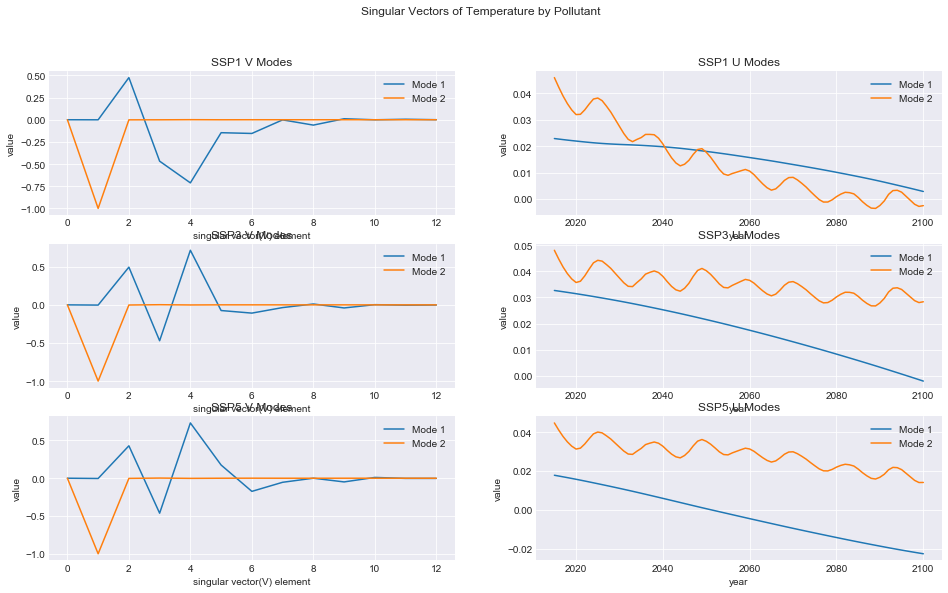

In [522]:
plt.figure(1)
plt.subplot(321)
plt.plot(st1)
plt.plot(st1,'rx')
plt.title('Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(322)
plt.loglog(st1)
plt.loglog(st1,'rx')
plt.title('LogLog Singular Values for SSP1')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(323)
plt.plot(st3)
plt.plot(st3,'rx')
plt.title('Singular Values for SSP3')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(324)
plt.loglog(st3)
plt.loglog(st3,'rx')
plt.title('LogLog Singular Values for SSP3')
plt.xlabel('mode')
plt.ylabel('singular value')

plt.subplot(325)
plt.plot(st5)
plt.plot(st5,'rx')
plt.title('Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.subplot(326)
plt.loglog(st5)
plt.loglog(st5,'rx')
plt.title('LogLog Singular Values for SSP5')
plt.xlabel('mode')
plt.ylabel('singular value')
plt.suptitle('Singular Values of Temperature by Pollutant')

plt.figure(2)
plt.subplot(321)
plt.plot(vt1[:,1],label='Mode 1')
plt.plot(vt1[:,2],label='Mode 2')
plt.title('SSP1 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(322)
plt.plot(years[start_indx:end_indx],ut1[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],ut1[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP1 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(323)
plt.plot(vt3[:,1],label='Mode 1')
plt.plot(vt3[:,2],label='Mode 2')
plt.title('SSP3 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(324)
plt.plot(years[start_indx:end_indx],ut3[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],ut3[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP3 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()

plt.subplot(325)
plt.plot(vt5[:,1],label='Mode 1')
plt.plot(vt5[:,2],label='Mode 2')
plt.title('SSP5 V Modes');plt.xlabel('singular vector(V) element');plt.ylabel('value');plt.legend()
plt.subplot(326)
plt.plot(years[start_indx:end_indx],ut5[start_indx:end_indx:,1],label='Mode 1')
plt.plot(years[start_indx:end_indx],ut5[start_indx:end_indx:,2],label='Mode 2')
plt.title('SSP5 U Modes');plt.xlabel('year');plt.ylabel('value');plt.legend()
plt.suptitle("Singular Vectors of Temperature by Pollutant")

Text(0.5, 0.98, 'Dominant Temperature Over Time Behavior')

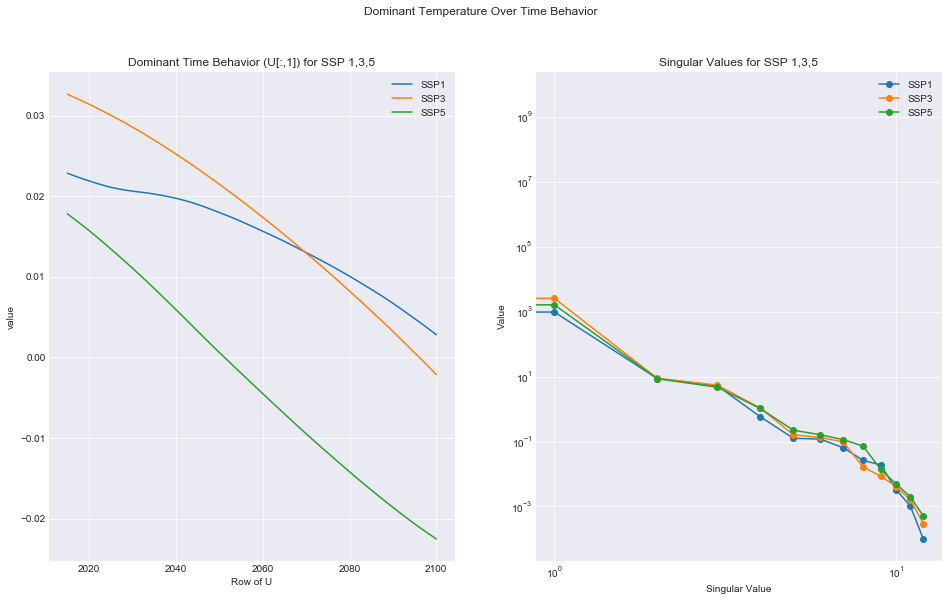

In [523]:
#dominant modes: 
plt.subplot(121)
plt.plot(years[start_indx:end_indx], ut1[start_indx:end_indx,1],label = 'SSP1')
plt.plot(years[start_indx:end_indx], ut3[start_indx:end_indx,1],label = 'SSP3')
plt.plot(years[start_indx:end_indx], ut5[start_indx:end_indx,1],label = 'SSP5')
plt.title('Dominant Time Behavior (U[:,1]) for SSP 1,3,5')
plt.xlabel('Row of U')
plt.ylabel('value')
plt.legend()
plt.subplot(122)
plt.loglog(st1,'o-',label = 'SSP1')
plt.loglog(st3,'o-',label = 'SSP3')
plt.loglog(st5,'o-',label = 'SSP5')
plt.title('Singular Values for SSP 1,3,5')
plt.xlabel('Singular Value')
plt.ylabel('Value')
plt.legend()
plt.suptitle("Dominant Temperature Over Time Behavior")

### Region SVD

In [344]:
#SSP5_regions_emission
ur1, sr1, vr1 = np.linalg.svd(SSP1_regions_emission, full_matrices=False)
ur3, sr3, vr3 = np.linalg.svd(SSP3_regions_emission, full_matrices=False)
ur5, sr5, vr5 = np.linalg.svd(SSP5_regions_emission, full_matrices=False)

Text(0, 0.5, 'Value')

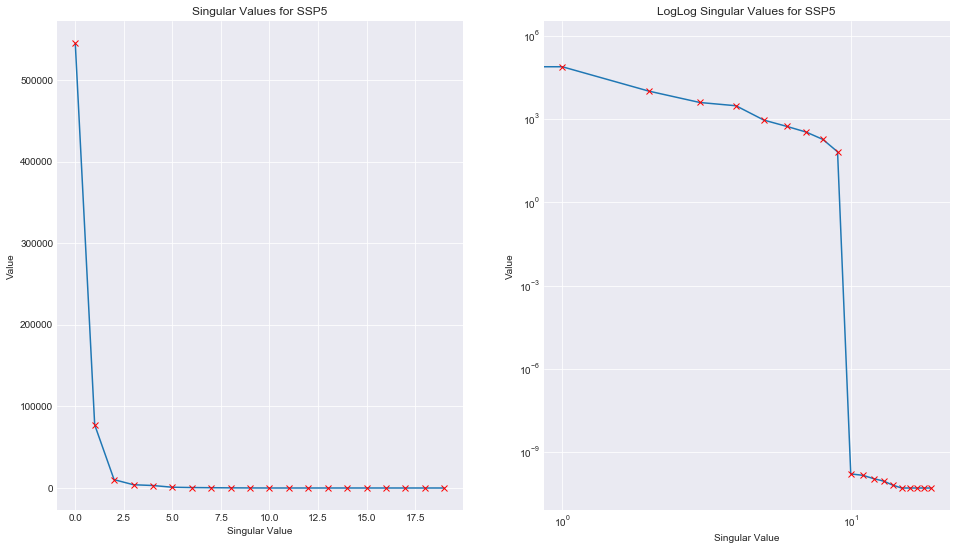

In [437]:
plt.subplot(121)
plt.plot(sr5[0:20])
plt.plot(sr5[0:20],'rx')
plt.title('Singular Values for SSP5')
plt.xlabel('Singular Value')
plt.ylabel('Value')
plt.subplot(122)
plt.loglog(sr5[0:20])
plt.loglog(sr5[0:20],'rx')
plt.title('LogLog Singular Values for SSP5')
plt.xlabel('Singular Value')
plt.ylabel('Value')

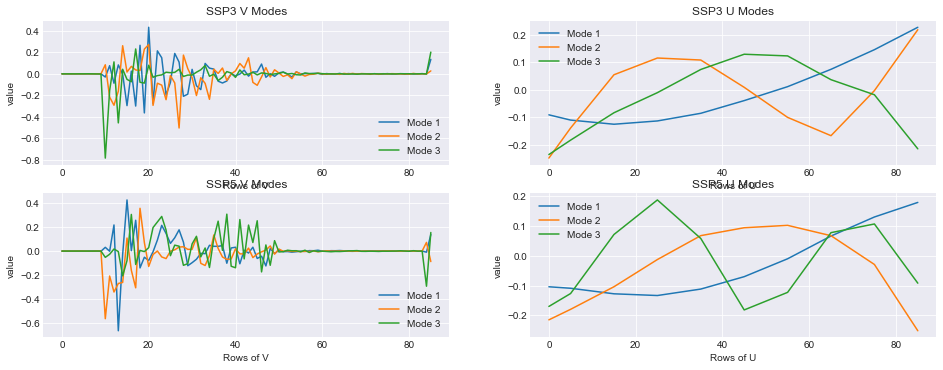

In [438]:
plt.subplot(121)
plt.plot(vr1[:,1],label='Mode 1')
plt.plot(vr1[:,2],label='Mode 2')
plt.plot(vr1[:,3],label='Mode 3')
#plt.plot(vr1[:,4],label='Mode 4')
#plt.plot(vr1[:,5],label='Mode 5')
plt.title('SSP1 V Modes')
plt.xlabel('Rows of V')
plt.ylabel('value')
plt.legend()
plt.subplot(122)
plt.plot(ur1[:,1],label='Mode 1')
plt.plot(ur1[:,2],label='Mode 2')
plt.plot(ur1[:,3],label='Mode 3')
#plt.plot(ur1[:,4],label='Mode 4')
#plt.plot(ur1[:,5],label='Mode 5')
plt.title('SSP1 U Modes')
plt.xlabel('Rows of U')
plt.ylabel('value')
plt.legend()

plt.subplot(323)
plt.plot(vr3[:,1],label='Mode 1')
plt.plot(vr3[:,2],label='Mode 2')
plt.plot(vr3[:,3],label='Mode 3')
#plt.plot(vr1[:,4],label='Mode 4')
#plt.plot(vr1[:,5],label='Mode 5')
plt.title('SSP3 V Modes')
plt.xlabel('Rows of V')
plt.ylabel('value')
plt.legend()
plt.subplot(324)
plt.plot(ur3[:,1],label='Mode 1')
plt.plot(ur3[:,2],label='Mode 2')
plt.plot(ur3[:,3],label='Mode 3')
#plt.plot(ur1[:,4],label='Mode 4')
#plt.plot(ur1[:,5],label='Mode 5')
plt.title('SSP3 U Modes')
plt.xlabel('Rows of U')
plt.ylabel('value')
plt.legend()

plt.subplot(325)
plt.plot(vr5[:,1],label='Mode 1')
plt.plot(vr5[:,2],label='Mode 2')
plt.plot(vr5[:,3],label='Mode 3')
#plt.plot(vr1[:,4],label='Mode 4')
#plt.plot(vr1[:,5],label='Mode 5')
plt.title('SSP5 V Modes')
plt.xlabel('Rows of V')
plt.ylabel('value')
plt.legend()
plt.subplot(326)
plt.plot(ur5[:,1],label='Mode 1')
plt.plot(ur5[:,2],label='Mode 2')
plt.plot(ur5[:,3],label='Mode 3')
#plt.plot(ur1[:,4],label='Mode 4')
#plt.plot(ur1[:,5],label='Mode 5')
plt.title('SSP5 U Modes')
plt.xlabel('Rows of U')
plt.ylabel('value')
plt.legend()


Text(0.5, 0.98, 'Dominant Temperature Over Time Behavior')

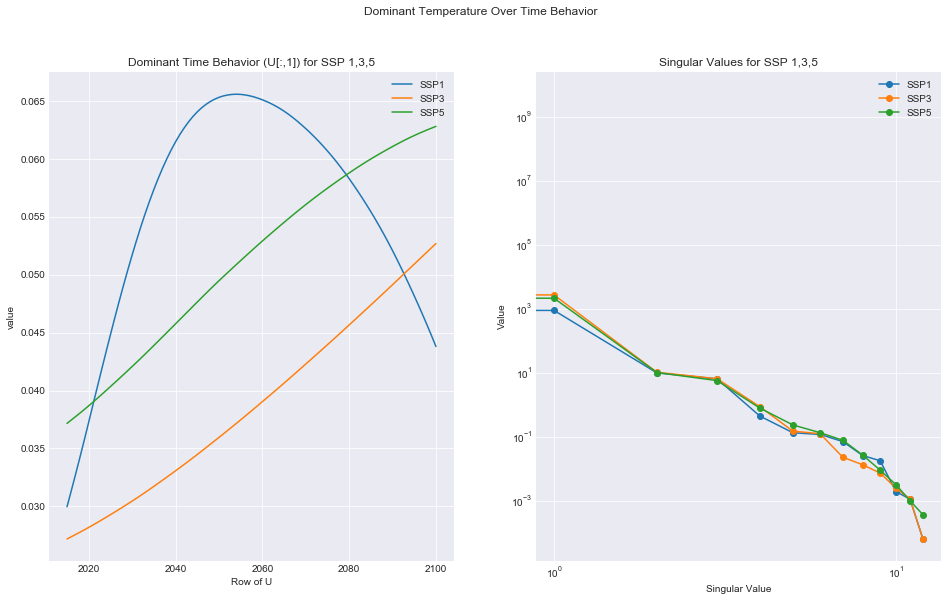

In [439]:
#dominant modes: 
plt.subplot(121)
plt.plot(years[start_indx:end_indx], ut1[start_indx:end_indx,1],label = 'SSP1')
plt.plot(years[start_indx:end_indx], ut3[start_indx:end_indx,1],label = 'SSP3')
plt.plot(years[start_indx:end_indx], ut5[start_indx:end_indx,1],label = 'SSP5')
plt.title('Dominant Time Behavior (U[:,1]) for SSP 1,3,5')
plt.xlabel('Row of U')
plt.ylabel('value')
plt.legend()
plt.subplot(122)
plt.loglog(st1,'o-',label = 'SSP1')
plt.loglog(st3,'o-',label = 'SSP3')
plt.loglog(st5,'o-',label = 'SSP5')
plt.title('Singular Values for SSP 1,3,5')
plt.xlabel('Singular Value')
plt.ylabel('Value')
plt.legend()
plt.suptitle("Dominant Temperature Over Time Behavior")